**Author :** Rutendo F. Sigauke

**Input  :** 

1. Further filtered significant pairs

2. SPEC Scores (From Lynn Sanford)

        - filt_qc123_all_specs_all.txt
        
        - filt_qc123_all_specs_maxval.txt
        
        - filt_qc123_all_specs_minval.txt

        
**Output :**

1. Figures (Summary of SPECs and PCC values)

# Libraries

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(cowplot)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Functions

## Filter pairs

In [2]:
removing_DoPAD_bidirs <- function(pairs, dist_DoPAD=15000, number_observed=10) {
    #' Remove pairs where the bidirectionals transcript is Downstream of Polyadenylation Site (DoPAD)
    #1. Subset by distance from TES
    pairs_dopad <- subset(pairs, abs(distance_tes) < dist_DoPAD)
    
    #2. Label bidirectionals that fall closer to the TES than to the TSS
    pairs_dopad$filter <- ifelse(abs(pairs_dopad$distance_tss) < abs(pairs_dopad$distance_tes),
                                        FALSE, TRUE)
    
    pairs_dopad_removing <- pairs_dopad[pairs_dopad$filter=='TRUE',]

    #This removes any pairs with bidirectionals in DoPAD as opposed to only removing the pair
    pairs_keeping <- pairs[!pairs$transcript_2 %in% pairs_dopad_removing$transcript_2,]
    
    pairs_keeping_nObs <- subset(pairs_keeping, nObs > number_observed)
    return(pairs_keeping_nObs)
}

# Load data

## Significant pairs

In [3]:
sig_pairs_path <- '/scratch/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/correlations/inter/significant'

##get paths for the tables
sig_pairs_path_files <- list.files(path=sig_pairs_path, 
                              pattern="*gz", 
                                   full.names=TRUE)

##load correlations
sig_pairs_path_DT_list <- lapply(sig_pairs_path_files, 
                                   data.table::fread) 


In [4]:
##combine to one data.table
sig_pairs_path_DT <- do.call(rbind, sig_pairs_path_DT_list)

#filter bidirectionals
sig_pairs_path_DT_filt <- removing_DoPAD_bidirs(sig_pairs_path_DT)
sig_pairs_path_DT_filt$pair_id <- paste0(sig_pairs_path_DT_filt$transcript_1,
                                         "~",
                                         sig_pairs_path_DT_filt$transcript_2)
nrow(sig_pairs_path_DT_filt)

[1] 1440890

## SPEC scores

In [5]:
spec <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/specs/filt_qc123_all_specs_all.txt')
head(spec, 3)

gene_transcript,blood,brain,breast,embryo,heart,intestine,kidney,liver,lung,prostate,skin,umbilical cord,uterus
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
DDX11L1:NR_046018.2,0.0000000,0.00000,0.006120903,0.03574407,0.04447492,0.06125405,0.03030785,0.000000,0.03597269,0.000000,0.03585838,0.0000000,0.3269174
WASH7P:NR_024540.1,0.6685395,0.20101,0.545039099,0.27985171,0.38909423,0.64885874,0.54002828,0.557627,0.50906931,0.398235,0.62235552,0.5763578,0.5639057
MIR1302-2:NR_036051.1,0.0000000,0.00000,0.000000000,0.00000000,0.00000000,0.00000000,0.01587302,0.000000,0.00000000,0.000000,0.00000000,0.0000000,0.0000000


In [6]:
spec_max <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/specs/filt_qc123_all_specs_maxval.txt')
colnames(spec_max) <- c('gene_transcript', 'max_spec','tissue_max_spec')
head(spec_max, 3)

gene_transcript,max_spec,tissue_max_spec
<chr>,<dbl>,<chr>
KLK3:NM_001648.2,1,prostate
KLK4:NM_001302961.2,1,prostate
SI:NM_001041.4,1,prostate


In [7]:
spec_min <- data.table::fread('/Users/rusi2317/projects/meta_analysis_qc/hg38/processed_data/specs/filt_qc123_all_specs_minval.txt')
colnames(spec_min) <- c('gene_transcript', 'min_spec','tissue_min_spec')
head(spec_min, 3)

gene_transcript,min_spec,tissue_min_spec
<chr>,<dbl>,<chr>
chrX:136861312-136861464,0.4370737,skin
chr8:144972859-144973089,0.4209265,heart
chr17:18807620-18807940,0.4208681,blood


# Analysis

## Gene SPEC scores

In [8]:
sig_pairs_filt_max_spec_genes <- merge(spec_max,
                                 sig_pairs_path_DT_filt,
                                 by.x='gene_transcript',
                                 by.y='transcript_1')

sig_pairs_filt_max_min_spec_genes <- merge(spec_min,
                                     sig_pairs_filt_max_spec_genes,
                                     by='gene_transcript')

colnames(sig_pairs_filt_max_min_spec_genes)[c(2,3,4,5)] <- c("transcript1_min_spec",
                                                             'transcript1_tissue_min_spec', 
                                                             'transcript1_max_spec',
                                                             'transcript1_tissue_max_spec')
dim(sig_pairs_filt_max_min_spec_genes)
head(sig_pairs_filt_max_min_spec_genes, 3)

[1] 1440890      27

gene_transcript,transcript1_min_spec,transcript1_tissue_min_spec,transcript1_max_spec,transcript1_tissue_max_spec,transcript1_chrom,transcript1_start,transcript1_stop,transcript1_score,transcript1_strand,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,0.0001101598,0.001118287,22,4.795451,-826764,-829978,upstream,breast,13.83648,A1BG-AS1:NR_015380.2~chr19:57525011-57525399
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,0.0003471491,0.003008575,20,4.397800,-769575,-772789,upstream,breast,12.57862,A1BG-AS1:NR_015380.2~chr19:57581960-57582828
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,0.0002334971,0.002141243,16,4.901830,-767890,-771104,upstream,breast,10.06289,A1BG-AS1:NR_015380.2~chr19:57583887-57584271


In [9]:
transcript1_max_spec_quantile <- quantile(sig_pairs_filt_max_min_spec_genes$transcript1_max_spec,
                                          probs = c(0,  0.25, 0.5, 0.75, 1))
signif(transcript1_max_spec_quantile, 4)

0%     25%     50%     75%    100% 
0.06281 0.74350 0.80260 0.86910 1.00000

In [10]:
sig_pairs_filt_max_min_spec_genes$transcript1_max_spec_bins <- ifelse(sig_pairs_filt_max_min_spec_genes$transcript1_max_spec > 0 &
                                                                     sig_pairs_filt_max_min_spec_genes$transcript1_max_spec < 0.743493973856625, "0-0.25",
                                                                     ifelse(sig_pairs_filt_max_min_spec_genes$transcript1_max_spec >=0.743493973856625 &
                                                                           sig_pairs_filt_max_min_spec_genes$transcript1_max_spec <0.80262309282965, "0.25-0.50",
                                                                           ifelse(sig_pairs_filt_max_min_spec_genes$transcript1_max_spec >=0.80262309282965 &
                                                                                 sig_pairs_filt_max_min_spec_genes$transcript1_max_spec <0.869120801138347,"0.50-0.75","0.75-1")))
head(sig_pairs_filt_max_min_spec_genes)

gene_transcript,transcript1_min_spec,transcript1_tissue_min_spec,transcript1_max_spec,transcript1_tissue_max_spec,transcript1_chrom,transcript1_start,transcript1_stop,transcript1_score,transcript1_strand,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,transcript1_max_spec_bins
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,1.118287e-03,22,4.795451,-826764,-829978,upstream,breast,13.83648,A1BG-AS1:NR_015380.2~chr19:57525011-57525399,0.25-0.50
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,3.008575e-03,20,4.397800,-769575,-772789,upstream,breast,12.57862,A1BG-AS1:NR_015380.2~chr19:57581960-57582828,0.25-0.50
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,2.141243e-03,16,4.901830,-767890,-771104,upstream,breast,10.06289,A1BG-AS1:NR_015380.2~chr19:57583887-57584271,0.25-0.50
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,1.218631e-03,26,4.577488,-700434,-703648,upstream,breast,16.35220,A1BG-AS1:NR_015380.2~chr19:57651293-57651777,0.25-0.50
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,2.559952e-18,159,10.807197,-521867,-525081,upstream,breast,100.00000,A1BG-AS1:NR_015380.2~chr19:57829899-57830305,0.25-0.50
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,8.722733e-22,159,12.176089,-74101,-77315,upstream,breast,100.00000,A1BG-AS1:NR_015380.2~chr19:58277617-58278119,0.25-0.50


In [11]:
unique(sig_pairs_filt_max_min_spec_genes$transcript1_max_spec_bins)

[1] "0.25-0.50" "0.50-0.75" "0.75-1"    "0-0.25"

In [41]:
median(sig_pairs_filt_max_min_spec_genes[sig_pairs_filt_max_min_spec_genes$transcript1_max_spec_bins=="0-0.25",]$pcc)
median(sig_pairs_filt_max_min_spec_genes[sig_pairs_filt_max_min_spec_genes$transcript1_max_spec_bins=="0.25-0.50",]$pcc)
median(sig_pairs_filt_max_min_spec_genes[sig_pairs_filt_max_min_spec_genes$transcript1_max_spec_bins=="0.50-0.75",]$pcc)
median(sig_pairs_filt_max_min_spec_genes[sig_pairs_filt_max_min_spec_genes$transcript1_max_spec_bins=="0.75-1",]$pcc)


[1] 0.6893021

[1] 0.6912955

[1] 0.7016085

[1] 0.7101007

## Bidirectional SPEC scores

In [12]:
sig_pairs_filt_max_spec_bidirs <- merge(spec_max,
                                 sig_pairs_path_DT_filt,
                                 by.x='gene_transcript',
                                 by.y='transcript_2')

sig_pairs_filt_max_min_spec_bidirs <- merge(spec_min,
                                     sig_pairs_filt_max_spec_bidirs,
                                     by='gene_transcript')

colnames(sig_pairs_filt_max_min_spec_bidirs )[c(2,3,4,5)] <- c("transcript2_min_spec",
                                                               'transcript2_tissue_min_spec', 
                                                               'transcript2_max_spec',
                                                               'transcript2_tissue_max_spec')

dim(sig_pairs_filt_max_min_spec_bidirs)
head(sig_pairs_filt_max_min_spec_bidirs, 3)

[1] 1440890      27

gene_transcript,transcript2_min_spec,transcript2_tissue_min_spec,transcript2_max_spec,transcript2_tissue_max_spec,transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,⋯,pval,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100232297,100267638,CWF19L1:NM_018294.6,.,⋯,7.240016e-19,5.046681e-16,142,10.299808,257701,222360,downstream,breast,89.30818,CWF19L1:NM_018294.6~chr10:100009743-100010131
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100237155,100237302,SNORA12:NR_002954.1,.,⋯,2.350835e-18,1.522700e-15,130,10.245339,227365,227218,downstream,breast,81.76101,SNORA12:NR_002954.1~chr10:100009743-100010131
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,99875570,99914092,DNMBP:NM_001318327.1,.,⋯,2.486303e-07,1.451352e-04,20,7.991905,-95845,-134367,upstream,embryo,74.07407,DNMBP:NM_001318327.1~chr10:100009743-100010131


In [13]:
transcript2_max_spec_quantile <- quantile(sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec,
                                          probs = c(0,  0.25, 0.5, 0.75, 1))
transcript2_max_spec_quantile 

0%        25%        50%        75%       100% 
0.05374324 0.63044167 0.73381153 0.81370520 1.00000000

In [14]:
sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec_bins <- ifelse(sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec > 0 &
                                                                     sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec < 0.630441673076695, "0-0.25",
                                                                     ifelse(sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec >=0.630441673076695 &
                                                                           sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec <0.733811526944755, "0.25-0.50",
                                                                           ifelse(sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec >=0.733811526944755 &
                                                                                 sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec <0.813705200576027,"0.50-0.75","0.75-1")))
head(sig_pairs_filt_max_min_spec_bidirs)

gene_transcript,transcript2_min_spec,transcript2_tissue_min_spec,transcript2_max_spec,transcript2_tissue_max_spec,transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,⋯,adj_p_BH,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,transcript2_max_spec_bins
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100232297,100267638,CWF19L1:NM_018294.6,.,⋯,5.046681e-16,142,10.299808,257701,222360,downstream,breast,89.30818,CWF19L1:NM_018294.6~chr10:100009743-100010131,0.50-0.75
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100237155,100237302,SNORA12:NR_002954.1,.,⋯,1.522700e-15,130,10.245339,227365,227218,downstream,breast,81.76101,SNORA12:NR_002954.1~chr10:100009743-100010131,0.50-0.75
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,99875570,99914092,DNMBP:NM_001318327.1,.,⋯,1.451352e-04,20,7.991905,-95845,-134367,upstream,embryo,74.07407,DNMBP:NM_001318327.1~chr10:100009743-100010131,0.50-0.75
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100535942,100559998,HIF1AN:NM_017902.3,.,⋯,2.928970e-04,20,7.496102,-526005,-550061,upstream,embryo,74.07407,HIF1AN:NM_017902.3~chr10:100009743-100010131,0.50-0.75
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100999807,101007833,LZTS2:NM_001318100.2,.,⋯,7.841275e-07,20,12.284128,-989870,-997896,upstream,embryo,74.07407,LZTS2:NM_001318100.2~chr10:100009743-100010131,0.50-0.75
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,99782639,99852594,ABCC2:NM_000392.5,.,⋯,9.715068e-03,22,3.651060,227298,157343,downstream,heart,100.00000,ABCC2:NM_000392.5~chr10:100009743-100010131,0.50-0.75


In [40]:
median(sig_pairs_filt_max_min_spec_bidirs[sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec_bins=="0-0.25",]$pcc)
median(sig_pairs_filt_max_min_spec_bidirs[sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec_bins=="0.25-0.50",]$pcc)
median(sig_pairs_filt_max_min_spec_bidirs[sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec_bins=="0.50-0.75",]$pcc)
median(sig_pairs_filt_max_min_spec_bidirs[sig_pairs_filt_max_min_spec_bidirs$transcript2_max_spec_bins=="0.75-1",]$pcc)

[1] 0.7262346

[1] 0.6914977

[1] 0.6823875

[1] 0.6931733

## SPEC vs PCC

### Genes

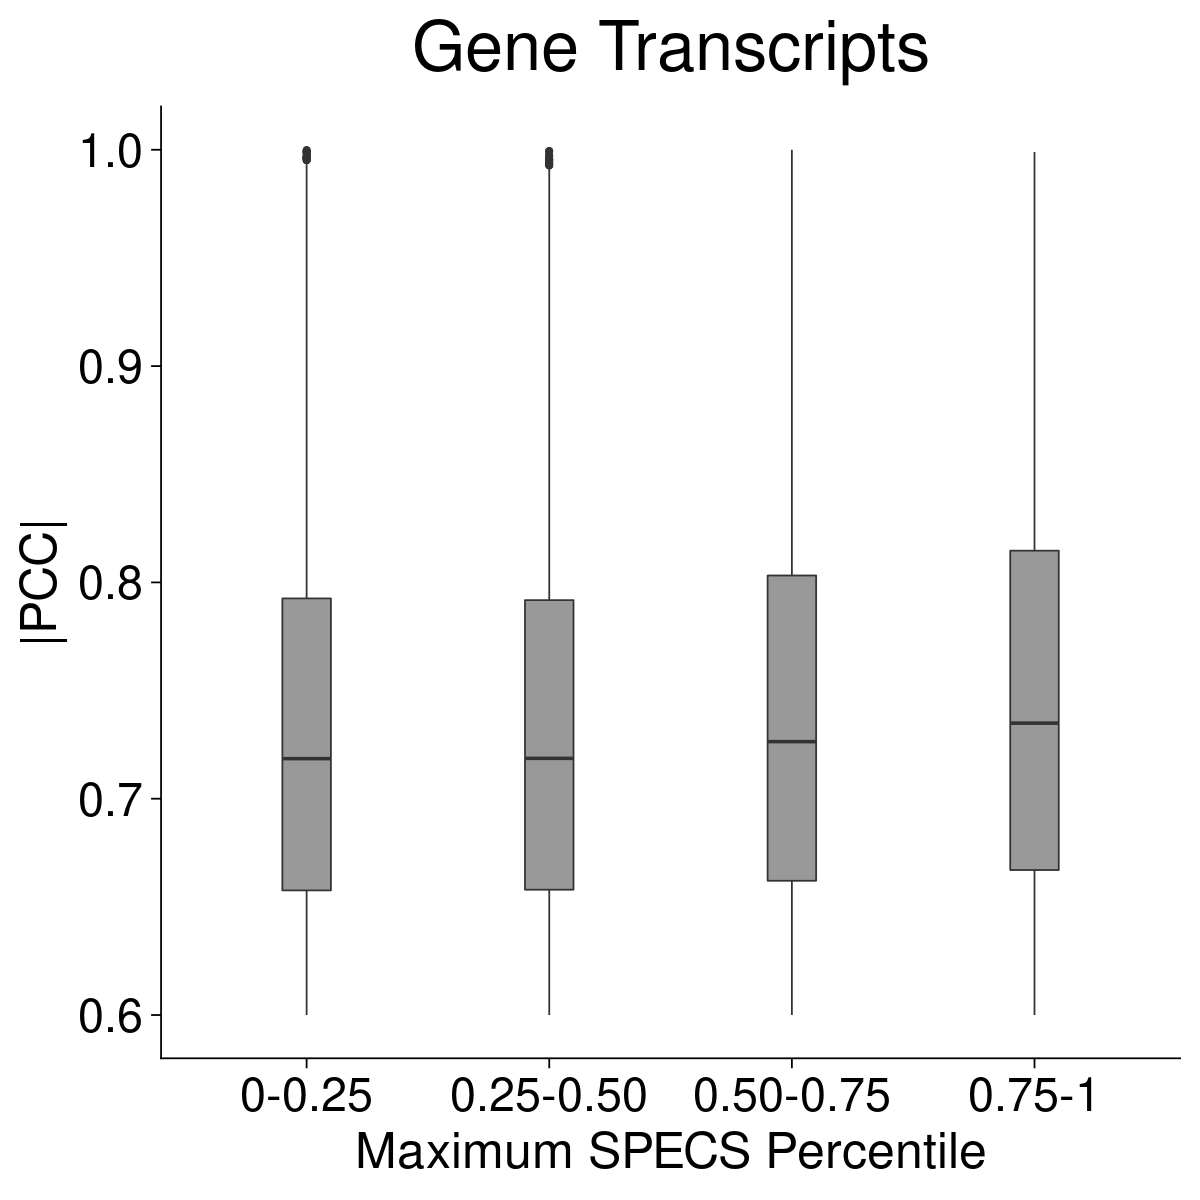

In [15]:
options(repr.plot.width=10, repr.plot.height=10)

gene_spec_pcc_violin_plot <- ggplot(sig_pairs_filt_max_min_spec_genes,
                          aes(x=as.factor(transcript1_max_spec_bins),
                              y=abs(pcc))) + 
  #geom_violin(trim=FALSE, fill="gray")+
  labs(title="Plot of length  by dose",x="Dose (mg)", y = "Length")+
  geom_boxplot(width=0.2, fill="gray60")+
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Maximum SPECS Percentile") +
ylab("|PCC|") +
ggtitle("Gene Transcripts") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

gene_spec_pcc_violin_plot

### Bidirectional

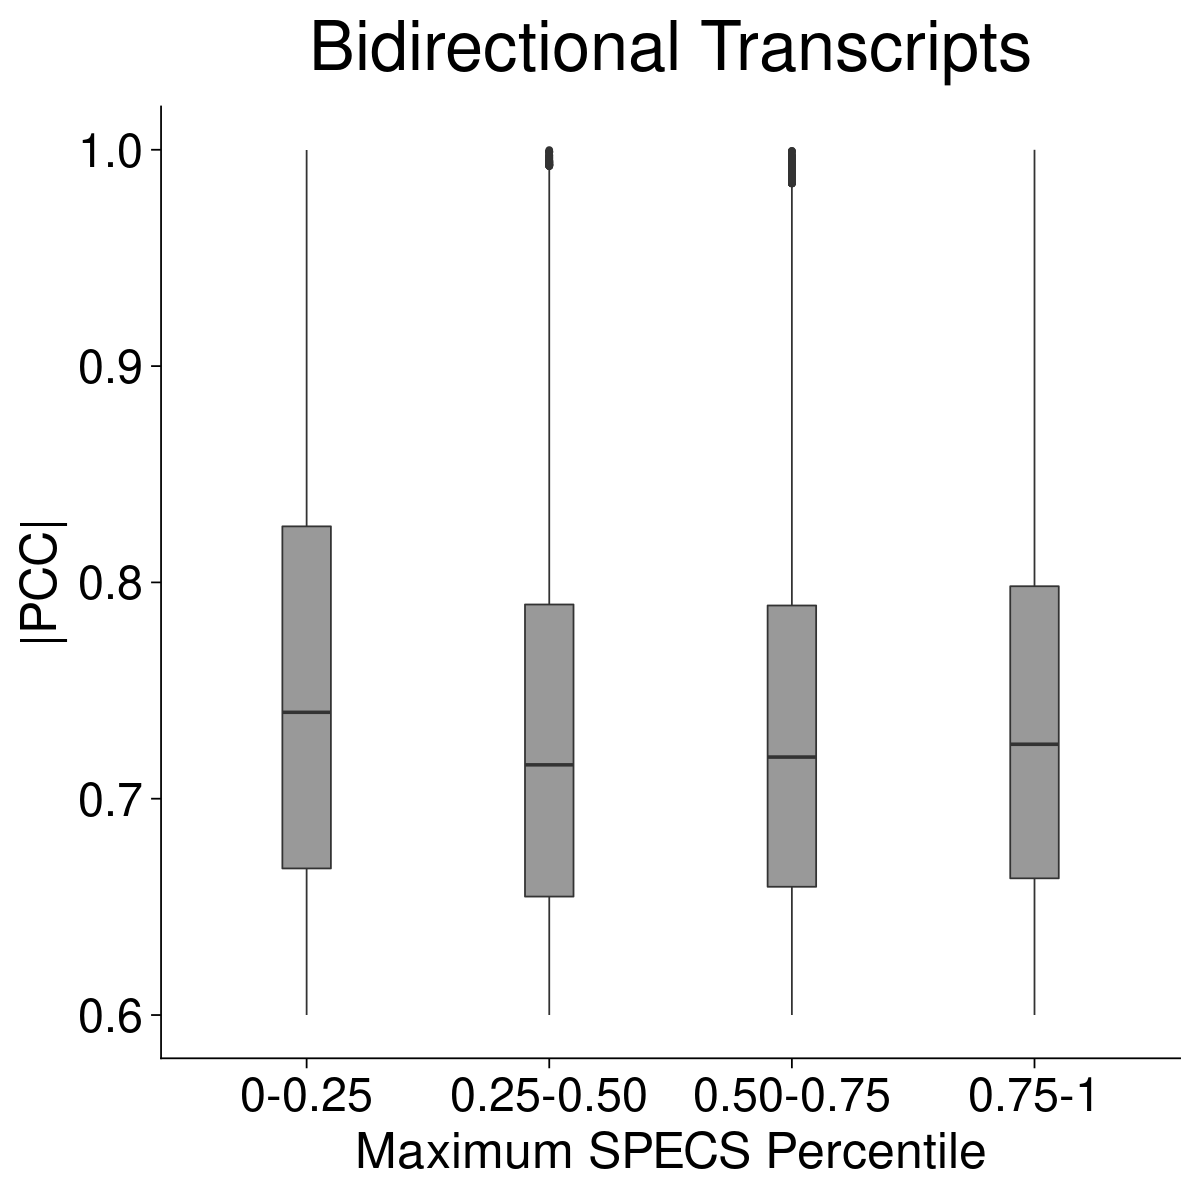

In [16]:
options(repr.plot.width=10, repr.plot.height=10)

bidir_spec_pcc_violin_plot <- ggplot(sig_pairs_filt_max_min_spec_bidirs,
                          aes(x=as.factor(transcript2_max_spec_bins),
                              y=abs(pcc))) + 
  geom_boxplot(width=0.2, fill="gray60")+
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Maximum SPECS Percentile") +
ylab("|PCC|") +
ggtitle("Bidirectional Transcripts") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

bidir_spec_pcc_violin_plot

## Check tissue agreement

In [17]:
sig_pairs_filt_max_min_spec_bidirs$same_tissue_spec_bidirs <- ifelse(sig_pairs_filt_max_min_spec_bidirs$transcript2_tissue_max_spec == sig_pairs_filt_max_min_spec_bidirs$tissue,
                                                                     "Yes", "No")
head(sig_pairs_filt_max_min_spec_bidirs)

gene_transcript,transcript2_min_spec,transcript2_tissue_min_spec,transcript2_max_spec,transcript2_tissue_max_spec,transcript1_chrom,transcript1_start,transcript1_stop,transcript_1,transcript1_score,⋯,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,transcript2_max_spec_bins,same_tissue_spec_bidirs
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100232297,100267638,CWF19L1:NM_018294.6,.,⋯,142,10.299808,257701,222360,downstream,breast,89.30818,CWF19L1:NM_018294.6~chr10:100009743-100010131,0.50-0.75,No
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100237155,100237302,SNORA12:NR_002954.1,.,⋯,130,10.245339,227365,227218,downstream,breast,81.76101,SNORA12:NR_002954.1~chr10:100009743-100010131,0.50-0.75,No
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,99875570,99914092,DNMBP:NM_001318327.1,.,⋯,20,7.991905,-95845,-134367,upstream,embryo,74.07407,DNMBP:NM_001318327.1~chr10:100009743-100010131,0.50-0.75,No
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100535942,100559998,HIF1AN:NM_017902.3,.,⋯,20,7.496102,-526005,-550061,upstream,embryo,74.07407,HIF1AN:NM_017902.3~chr10:100009743-100010131,0.50-0.75,No
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,100999807,101007833,LZTS2:NM_001318100.2,.,⋯,20,12.284128,-989870,-997896,upstream,embryo,74.07407,LZTS2:NM_001318100.2~chr10:100009743-100010131,0.50-0.75,No
chr10:100009743-100010131,0.1021658,prostate,0.805395,kidney,chr10,99782639,99852594,ABCC2:NM_000392.5,.,⋯,22,3.651060,227298,157343,downstream,heart,100.00000,ABCC2:NM_000392.5~chr10:100009743-100010131,0.50-0.75,No


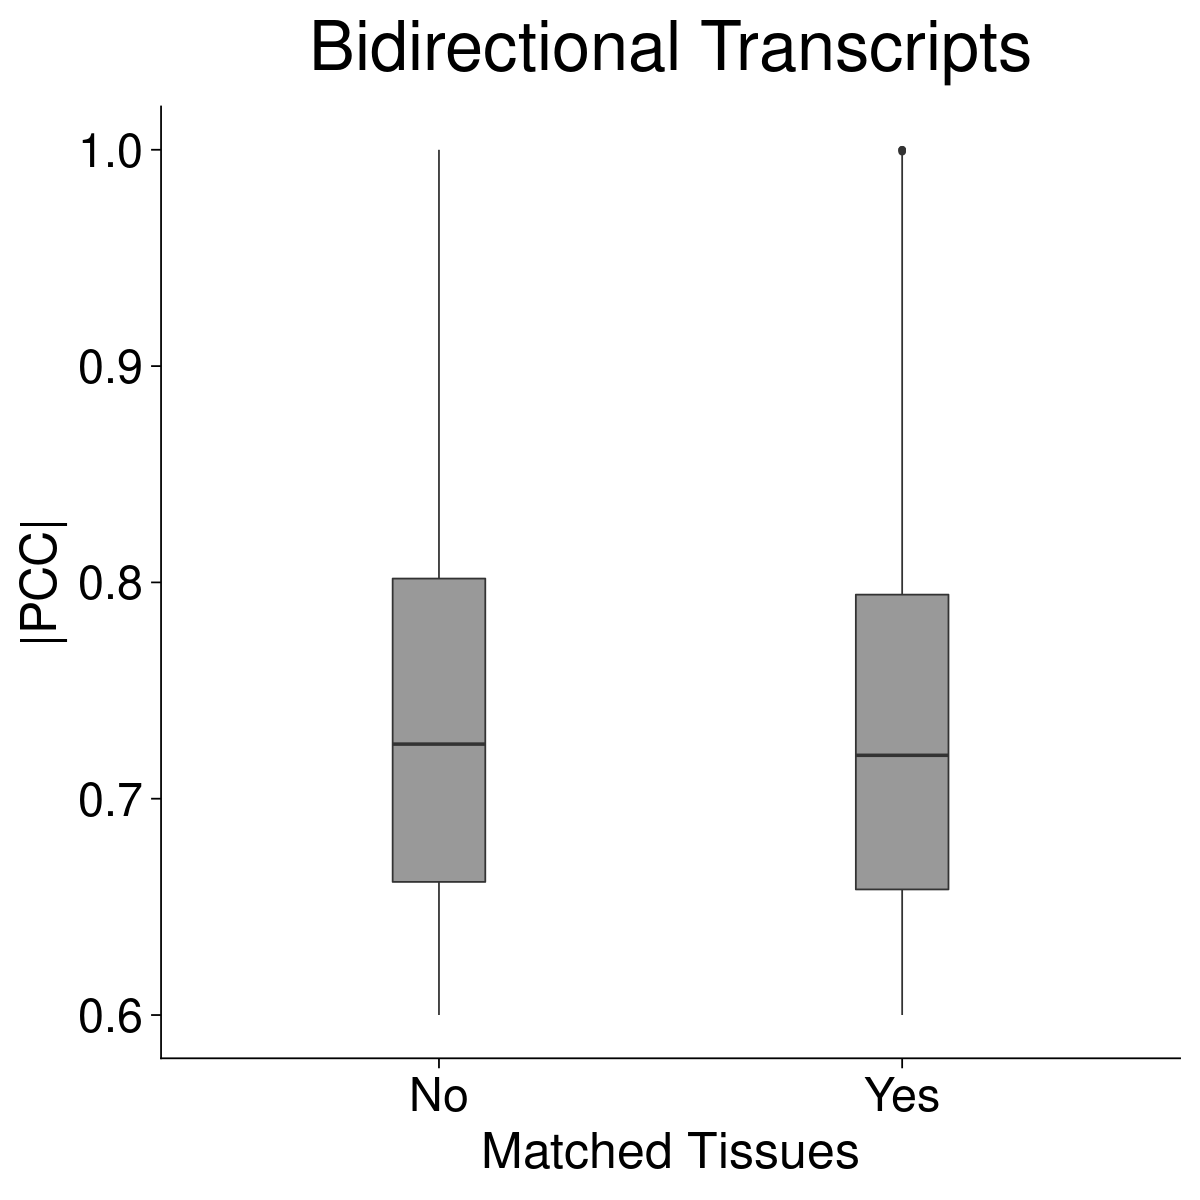

In [18]:
options(repr.plot.width=10, repr.plot.height=10)

bidir_spec_pcc_tissues_plot <- ggplot(sig_pairs_filt_max_min_spec_bidirs,
                          aes(x=as.factor(same_tissue_spec_bidirs),
                              y=abs(pcc))) + 
  geom_boxplot(width=0.2, fill="gray60")+
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Matched Tissues") +
ylab("|PCC|") +
ggtitle("Bidirectional Transcripts") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

bidir_spec_pcc_tissues_plot

In [19]:
sig_pairs_filt_max_min_spec_genes$same_tissue_spec_genes <- ifelse(sig_pairs_filt_max_min_spec_genes$transcript1_tissue_max_spec == sig_pairs_filt_max_min_spec_genes$tissue,
                                                                     "Yes", "No")
head(sig_pairs_filt_max_min_spec_genes)

gene_transcript,transcript1_min_spec,transcript1_tissue_min_spec,transcript1_max_spec,transcript1_tissue_max_spec,transcript1_chrom,transcript1_start,transcript1_stop,transcript1_score,transcript1_strand,⋯,nObs,t,distance_tss,distance_tes,position,tissue,percent_transcribed_both,pair_id,transcript1_max_spec_bins,same_tissue_spec_genes
<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,⋯,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,22,4.795451,-826764,-829978,upstream,breast,13.83648,A1BG-AS1:NR_015380.2~chr19:57525011-57525399,0.25-0.50,No
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,20,4.397800,-769575,-772789,upstream,breast,12.57862,A1BG-AS1:NR_015380.2~chr19:57581960-57582828,0.25-0.50,No
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,16,4.901830,-767890,-771104,upstream,breast,10.06289,A1BG-AS1:NR_015380.2~chr19:57583887-57584271,0.25-0.50,No
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,26,4.577488,-700434,-703648,upstream,breast,16.35220,A1BG-AS1:NR_015380.2~chr19:57651293-57651777,0.25-0.50,No
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,159,10.807197,-521867,-525081,upstream,breast,100.00000,A1BG-AS1:NR_015380.2~chr19:57829899-57830305,0.25-0.50,No
A1BG-AS1:NR_015380.2,0.05663646,liver,0.7645817,heart,chr19,58351969,58355183,.,+,⋯,159,12.176089,-74101,-77315,upstream,breast,100.00000,A1BG-AS1:NR_015380.2~chr19:58277617-58278119,0.25-0.50,No


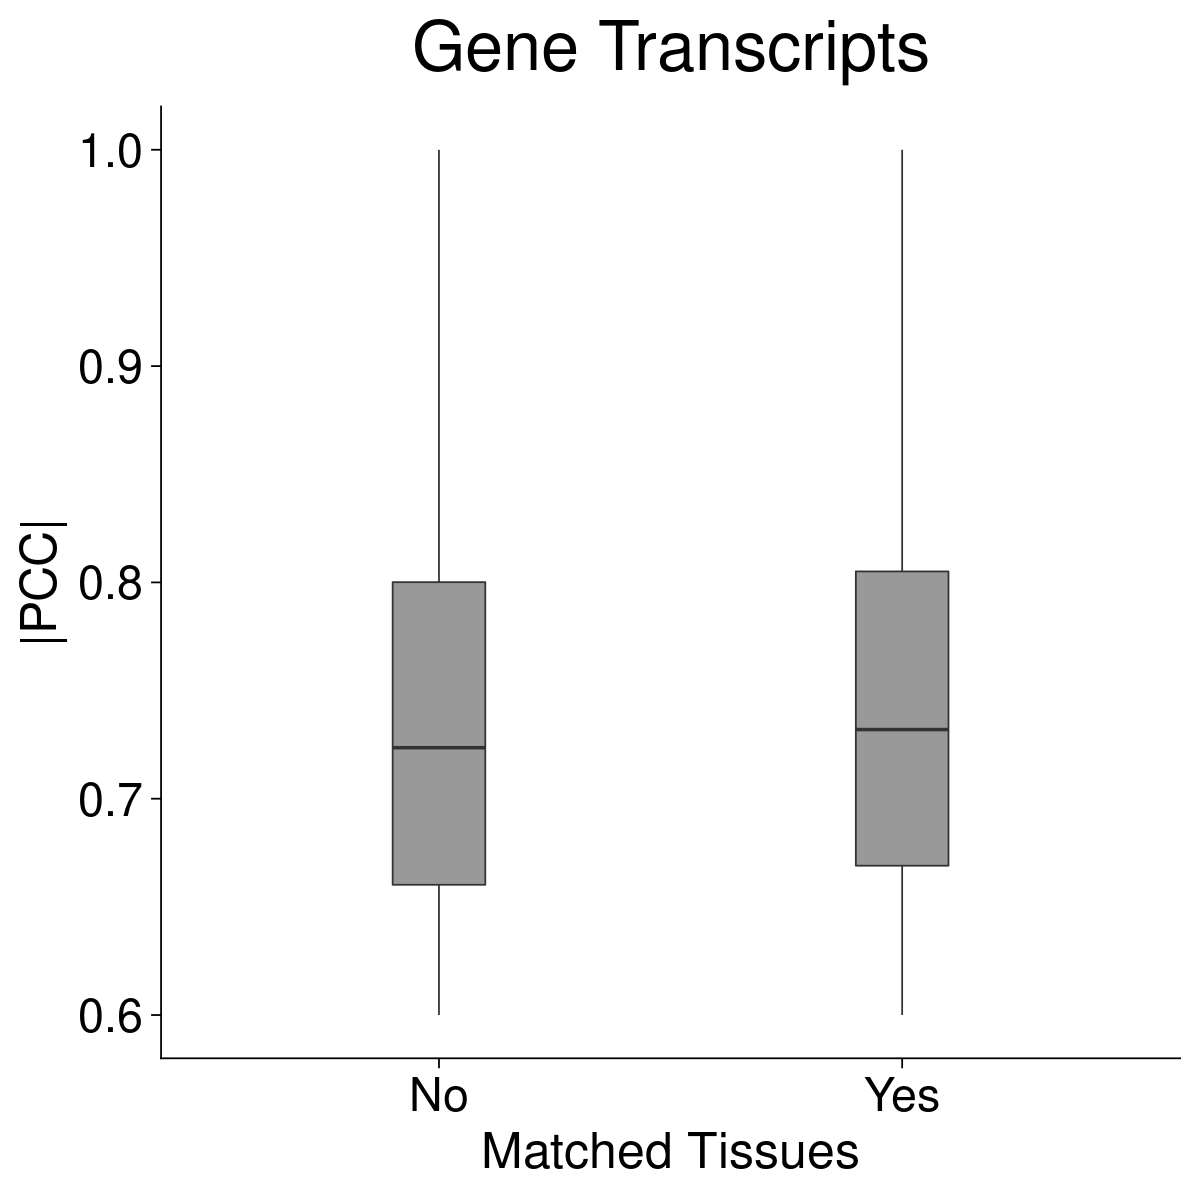

In [20]:
options(repr.plot.width=10, repr.plot.height=10)

gene_spec_pcc_tissues_plot <- ggplot(sig_pairs_filt_max_min_spec_genes,
                          aes(x=as.factor(same_tissue_spec_genes),
                              y=abs(pcc))) + 
  geom_boxplot(width=0.2, fill="gray60")+
theme_cowplot(24) + 
ggtitle(" ") +
xlab("Matched Tissues") +
ylab("|PCC|") +
ggtitle("Gene Transcripts") +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 36), 
      axis.title = element_text(size = 30), 
      axis.text = element_text(size = 28)) 

gene_spec_pcc_tissues_plot

In [21]:
median(abs(subset(sig_pairs_filt_max_min_spec_genes, same_tissue_spec_genes=='Yes')$pcc))
median(abs(subset(sig_pairs_filt_max_min_spec_genes, same_tissue_spec_genes=='No')$pcc))

[1] 0.7319695

[1] 0.723581

In [22]:
median(abs(subset(sig_pairs_filt_max_min_spec_bidirs, same_tissue_spec_bidirs=='Yes')$pcc))
median(abs(subset(sig_pairs_filt_max_min_spec_bidirs, same_tissue_spec_bidirs=='No')$pcc))

[1] 0.7200647

[1] 0.7252391

## Number of tissues a pair is found 

In [23]:
no_tissues_for_pair <- as.data.frame(table(sig_pairs_filt_max_min_spec_bidirs$pair_id))
nrow(no_tissues_for_pair)
head(no_tissues_for_pair)

[1] 1094246

,Var1,Freq
,<fct>,<int>
1,A1BG-AS1:NR_015380.2~chr19:57479710-57479990,1
2,A1BG-AS1:NR_015380.2~chr19:57480338-57480600,2
3,A1BG-AS1:NR_015380.2~chr19:57484184-57485124,1
4,A1BG-AS1:NR_015380.2~chr19:57487594-57487814,2
5,A1BG-AS1:NR_015380.2~chr19:57525011-57525399,1
6,A1BG-AS1:NR_015380.2~chr19:57527152-57527546,1


In [24]:
no_tissues_for_pair_genes <- merge(no_tissues_for_pair,
                                   unique(sig_pairs_filt_max_min_spec_genes[,
                                                                            c('pair_id',
                                                                              'transcript1_max_spec')]),
                                   by.x='Var1',
                                    by.y='pair_id')

no_tissues_for_pair_genes_bidirs <- merge(no_tissues_for_pair_genes,
                                   unique(sig_pairs_filt_max_min_spec_bidirs[,
                                                                             c('pair_id',
                                                                               'transcript2_max_spec')]),
                                   by.x='Var1',
                                    by.y='pair_id')
nrow(no_tissues_for_pair_genes_bidirs)
head(no_tissues_for_pair_genes_bidirs)

[1] 1094246

,Var1,Freq,transcript1_max_spec,transcript2_max_spec
,<fct>,<int>,<dbl>,<dbl>
1,A1BG-AS1:NR_015380.2~chr19:57479710-57479990,1,0.7645817,0.6729627
2,A1BG-AS1:NR_015380.2~chr19:57480338-57480600,2,0.7645817,0.5747560
3,A1BG-AS1:NR_015380.2~chr19:57484184-57485124,1,0.7645817,0.6119808
4,A1BG-AS1:NR_015380.2~chr19:57487594-57487814,2,0.7645817,0.7470502
5,A1BG-AS1:NR_015380.2~chr19:57525011-57525399,1,0.7645817,0.5128387
6,A1BG-AS1:NR_015380.2~chr19:57527152-57527546,1,0.7645817,0.7831925


In [25]:
length(unique(no_tissues_for_pair_genes_bidirs$Var1))

[1] 1094246

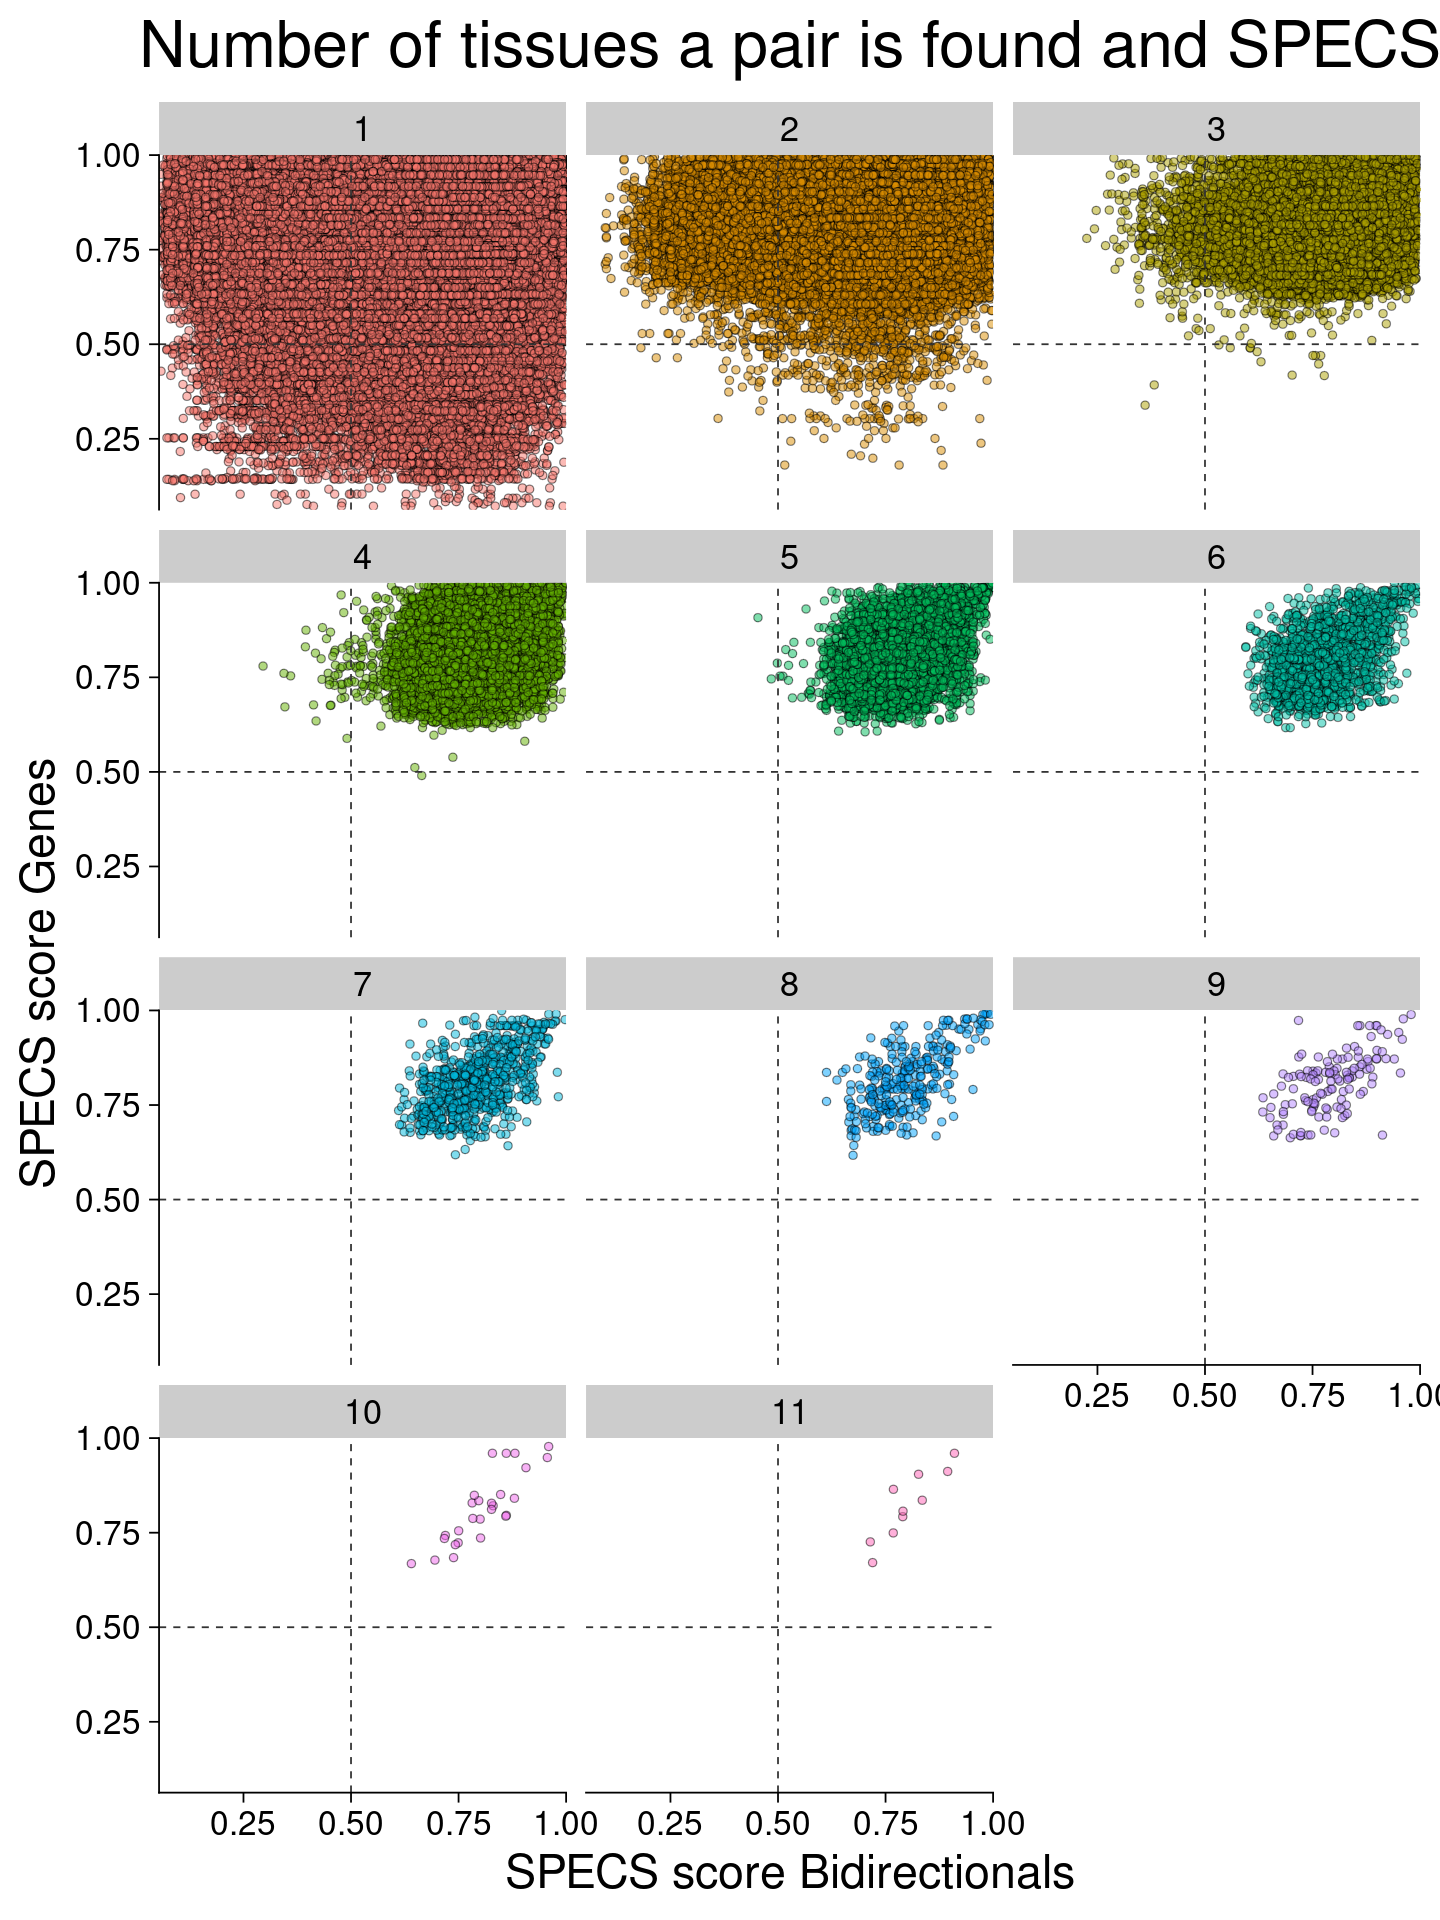

In [26]:
options(repr.plot.width=12, repr.plot.height=16)
num_tissues_spec_genes_bidirs_plot <- ggplot(no_tissues_for_pair_genes_bidirs, 
                       aes(x=transcript2_max_spec, 
                           y=transcript1_max_spec,
                          fill=as.factor(Freq))) + 
  geom_point(alpha=0.5, size=2, shape=21)+
facet_wrap(~ Freq, ncol=3) +
geom_hline(yintercept=0.5, linetype="dashed", color = "gray20") +
geom_vline(xintercept=0.5, linetype="dashed", color = "gray20") +
ggtitle("Number of tissues a pair is found and SPECS") +
xlab("SPECS score Bidirectionals") +
ylab("SPECS score Genes") +
theme_cowplot(24) +
scale_y_continuous(expand = c(0, 0),
                   breaks=c(0,0.25,0.5,0.75,1)) +
scale_x_continuous(expand = c(0, 0),
                   breaks=c(0,0.25,0.5,0.75,1)) +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20),
     legend.position = "none") 

num_tissues_spec_genes_bidirs_plot

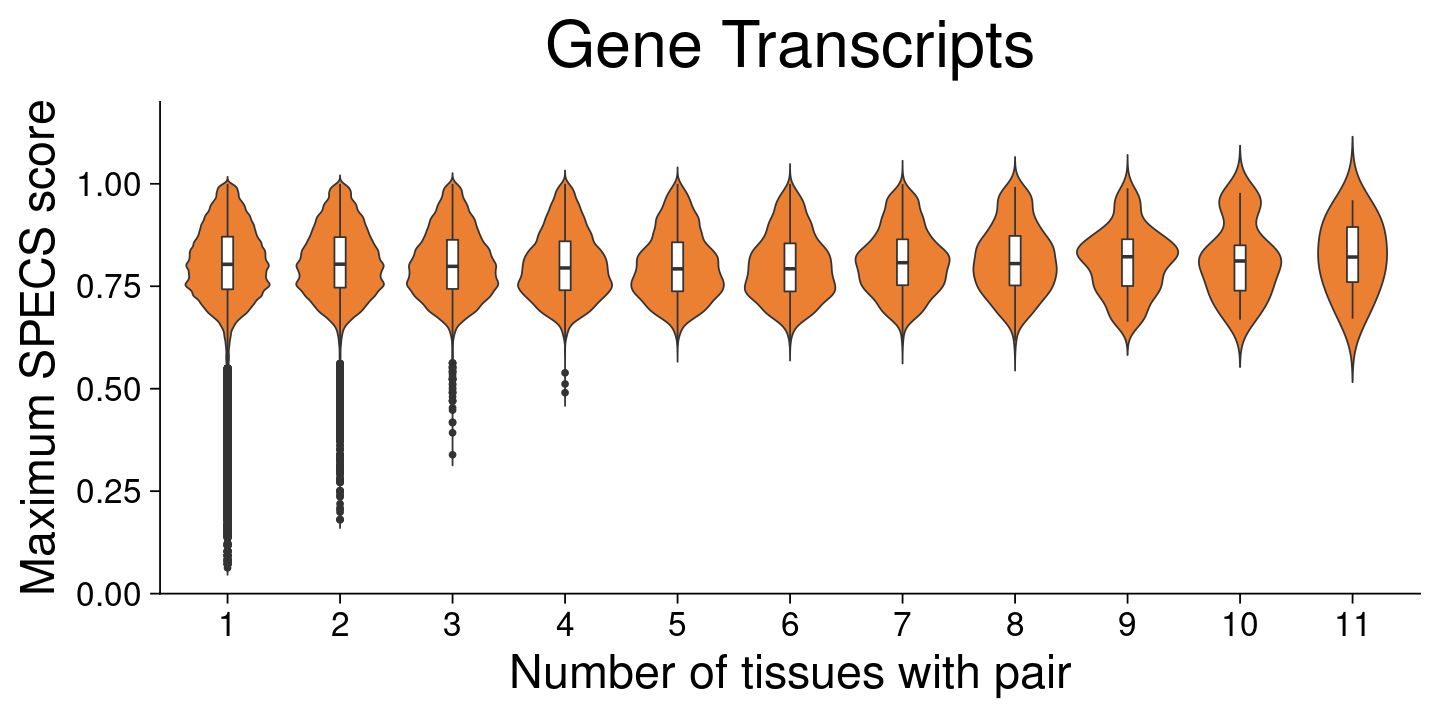

In [27]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_spec_genes_plot <- ggplot(no_tissues_for_pair_genes_bidirs, 
                       aes(x=as.factor(Freq), 
                           y=transcript1_max_spec)) + 
  geom_violin(trim=FALSE, fill="#e66101", alpha=0.8)+
  geom_boxplot(width=0.1)+
ggtitle("Gene Transcripts") +
xlab("Number of tissues with pair") + 
ylab("Maximum SPECS score") +
theme_cowplot(24) +
scale_y_continuous(expand = c(0, 0),
                   breaks=c(0,0.25,0.5,0.75,1), 
                   limits=c(0,1.2)) +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_spec_genes_plot

In [28]:
ggsave(num_tissues_spec_genes_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_tissues_spec_genes_plot.pdf',
      bg = "transparent")

ggsave(num_tissues_spec_genes_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_tissues_spec_genes_plot.png',
      bg = "transparent")

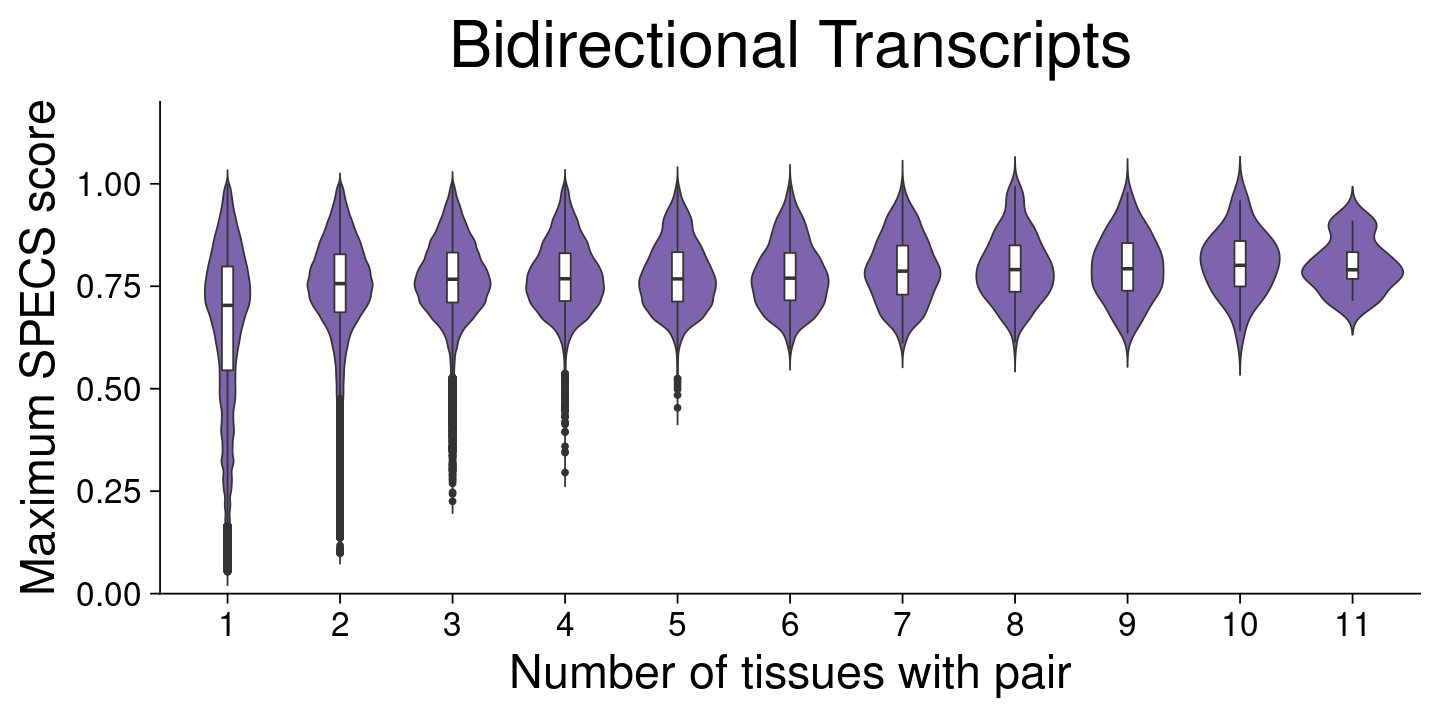

In [29]:
options(repr.plot.width=12, repr.plot.height=6)
num_tissues_spec_bidirs_plot <- ggplot(no_tissues_for_pair_genes_bidirs, 
                       aes(x=as.factor(Freq), 
                           y=transcript2_max_spec)) + 
  geom_violin(trim=FALSE, fill="#5e3c99", alpha=0.8)+
  geom_boxplot(width=0.1)+
ggtitle("Bidirectional Transcripts") +
xlab("Number of tissues with pair") + 
ylab("Maximum SPECS score") +
theme_cowplot(24) +
scale_y_continuous(expand = c(0, 0),
                   breaks=c(0,0.25,0.5,0.75,1),
                   limits=c(0,1.2)) +
theme(plot.title = element_text(hjust = 0.5, face='plain'),
      title = element_text(size = 34), 
      axis.title = element_text(size = 28), 
      axis.text.x = element_text(size = 20),
      axis.text.y = element_text(size = 20)) 

num_tissues_spec_bidirs_plot

In [30]:
ggsave(num_tissues_spec_bidirs_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_tissues_spec_bidirs_plot.pdf',
      bg = "transparent")

ggsave(num_tissues_spec_bidirs_plot, width = 12, height = 6,
       filename = '/Users/rusi2317/projects/meta_analysis_qc/hg38/paper_figures/num_tissues_spec_bidirs_plot.png',
      bg = "transparent")

# Session Information

In [31]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] cowplot_1.1.1     ggplot2_3.3.6     dplyr_1.0.10      data.table_1.14.2

loaded via a namespace (and not attached):
 [1] pillar_1.8.1      compiler_3.6.0    R.methodsS3_1.8.2 R.utils_2.12.0   
 [5] base64enc_0.1-3   tools_3.6.0       digest_0.6.29     uuid_1.1-0       
 [9] jsonlite_1.8.0    evaluate_0.16     lifecycle_1.0.3   ti